In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from classes import moments, parameters, var
from solver_funcs import fixed_point_solver
import matplotlib.pylab as pylab
from data_funcs import write_calibration_results
import seaborn as sns
from adjustText import adjust_text
from tqdm import tqdm
from IPython.display import display, HTML,Markdown, Latex

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
data_path = 'data/'
results_path = 'calibration_results_matched_economy/'
cf_path = 'counterfactual_recaps/unilateral_patent_protection/'
nash_eq_path = 'nash_eq_recaps/'
coop_eq_path = 'coop_eq_recaps/'

baseline = '501'
variation = '2.0'

if variation == 'baseline':
    run_path = results_path+baseline+'/'
else:
    run_path = f'calibration_results_matched_economy/baseline_{baseline}_variations/{variation}/'
    
p_baseline = parameters(n=7,s=2)
p_baseline.load_data(run_path)

m_baseline = moments()
m_baseline.load_data()
m_baseline.load_run(run_path)

sol_baseline = var.var_from_vector(p_baseline.guess, p_baseline, compute=True, context = 'counterfactual')
sol_baseline.scale_P(p_baseline)
sol_baseline.compute_non_solver_quantities(p_baseline)

m_baseline.compute_moments(sol_baseline,p_baseline)
m_baseline.compute_moments_deviations()

# A world with no patent
## We are exploring what happens if countries have infinitely weak patent protection

In [64]:
l_sol = []
l_p = []
deltas = np.logspace(0,3,301)
p = p_baseline.copy()
for i,delt in enumerate(deltas):
    p.delta[:,1] = p_baseline.delta[:,1]*delt
    sol, sol_c = fixed_point_solver(p,x0=p.guess,
                                context = 'counterfactual',
                                cobweb_anim=False,tol =1e-15,
                                accelerate=False,
                                accelerate_when_stable=True,
                                cobweb_qty='profit',
                                plot_convergence=False,
                                plot_cobweb=False,
                                safe_convergence=0.001,
                                disp_summary=False,
                                # apply_bound_psi_star = False,
                                damping = 10,
                                max_count = 1e4,
                                accel_memory = 50, 
                                accel_type1=True, 
                                accel_regularization=1e-10,
                                accel_relaxation=0.5, 
                                accel_safeguard_factor=1, 
                                accel_max_weight_norm=1e6,
                                damping_post_acceleration=5
                                # damping=10
                                  # apply_bound_psi_star=True
                                )
    sol_c.compute_non_solver_quantities(p)
    sol_c.compute_consumption_equivalent_welfare(p,sol_baseline)
    sol_c.compute_world_welfare_changes(p,sol_baseline)
    if sol.status != 'successful':
        print('failed',delt)
        break
    p.guess = sol_c.vector_from_var()
    l_sol.append(sol_c)
    l_p.append(p)

With patent protection strength decreasing proportionally, the countries and world aggregate welfares and growth rates would evolve as :

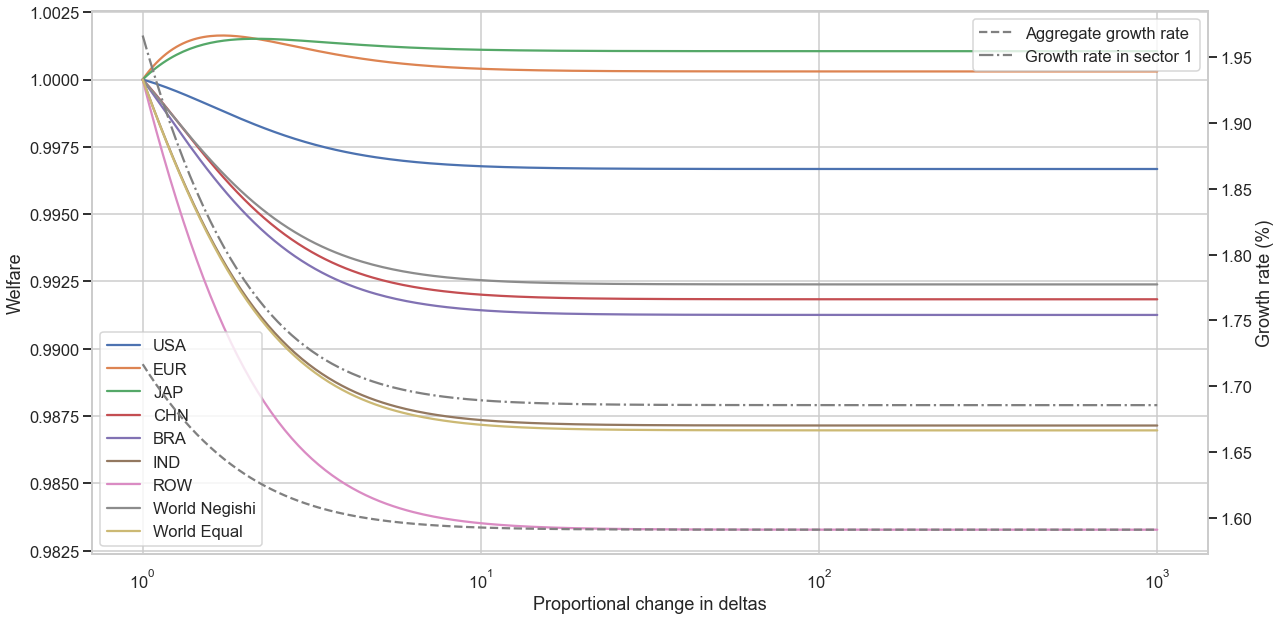

In the approximately no patent protection world, the growth rate would be 1.59% and the welfares would be :

,Welfares in no patent proctection world
USA,0.996677
EUR,1.000301
JAP,1.001054
CHN,0.991836
BRA,0.991255
IND,0.987147
ROW,0.983276
Negishi,0.992389
Equal,0.986966


In [63]:
welfares = pd.DataFrame(columns = ['deltas']+p_baseline.countries)

welfares['deltas'] = deltas

display(Markdown(f'With patent protection strength decreasing proportionally, the countries and world aggregate welfares and growth rates would evolve as :'))

fig, ax = plt.subplots()
ax2 = ax.twinx()
for i,c in enumerate(p_baseline.countries):
    welfares[c] = [sol.cons_eq_welfare[i] for sol in l_sol]
    ax.plot(welfares['deltas'],welfares[c],color=sns.color_palette()[i],label=c)

welfares['Negishi'] = [sol.cons_eq_negishi_welfare_change for sol in l_sol]
ax.plot(welfares['deltas'],welfares['Negishi'],color=sns.color_palette()[i+1],label='World Negishi')

welfares['Equal'] = [sol.cons_eq_pop_average_welfare_change for sol in l_sol]
ax.plot(welfares['deltas'],welfares['Equal'],color=sns.color_palette()[i+2],label='World Equal')
    
ax2.plot(welfares['deltas'],np.array([sol.g for sol in l_sol])*100, label = 'Aggregate growth rate',color='grey',ls='--')
ax2.set_ylabel('Growth rate (%)')
ax2.plot(welfares['deltas'],np.array([sol.g_s[1] for sol in l_sol])*100, label = 'Growth rate in sector 1',color='grey',ls='-.')

ax.set_xlabel('Proportional change in deltas')
ax.set_ylabel('Welfare')
plt.xscale('log')
ax.legend()
ax2.legend()
ax2.grid(False)
plt.show()

display(Markdown(f'In the approximately no patent protection world, the growth rate would be {l_sol[-1].g:.2%} and the welfares would be :'))

table_to_display = pd.DataFrame(welfares.iloc[-1])
table_to_display.columns = ['Welfares in no patent proctection world']
display(table_to_display.iloc[1:])

# Continuous change from Cooperative equilibrium with Equal weights to Negishi weights
## The idea is to see how the cooperative optimum changes if we reduce opportunity for re-distribution

We compute the world consumption equivalent welfare as 
$$CE_{equal}=\left( \frac{\sum_{n}\Lambda_{n}^{\frac{1}{\gamma }}\widetilde{C}_{n}^{%
\frac{\gamma -1}{\gamma }}}{\sum_{n}\Lambda_{n}^{\frac{1}{\gamma }}\left( 
\widetilde{C}_{n}^{B}\right) ^{\frac{\gamma -1}{\gamma }}}\right) ^{\frac{%
\gamma }{\gamma -1}}\left( \frac{\rho -g^{B}\left( 1-\frac{1}{\gamma }%
\right) }{\rho -g\left( 1-\frac{1}{\gamma }\right) }\right) ^{\frac{\gamma }{%
\gamma -1}}$$
And to make the continuous change from equal to Negishi, we use $$\Lambda_n = L^{1-\lambda}_n {C^B_n}^{\lambda}$$
For $$\lambda = 0$$ we have the equal-weights cooperative equilibrium and $$\lambda = 1$$ corresponds to the Negishi-weighted cooperative equilibrium.

The results are there is only two possible corner solutions, with EUR having a threshold change from strong patent protection contributing to the World welfare to weak patent protection contributing to their own welfare

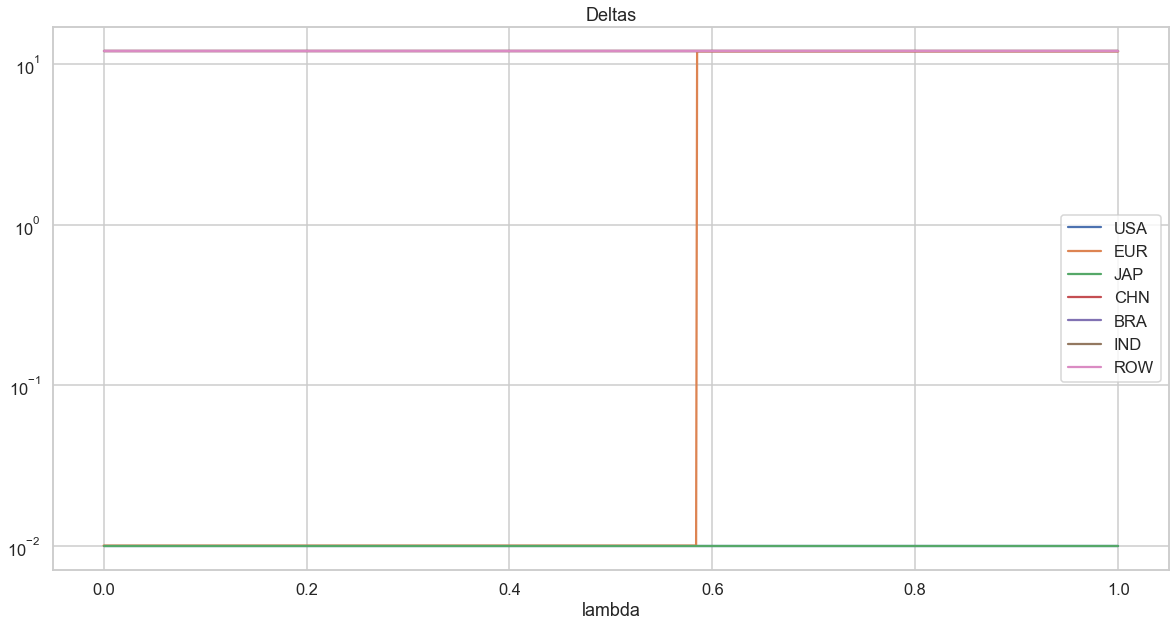

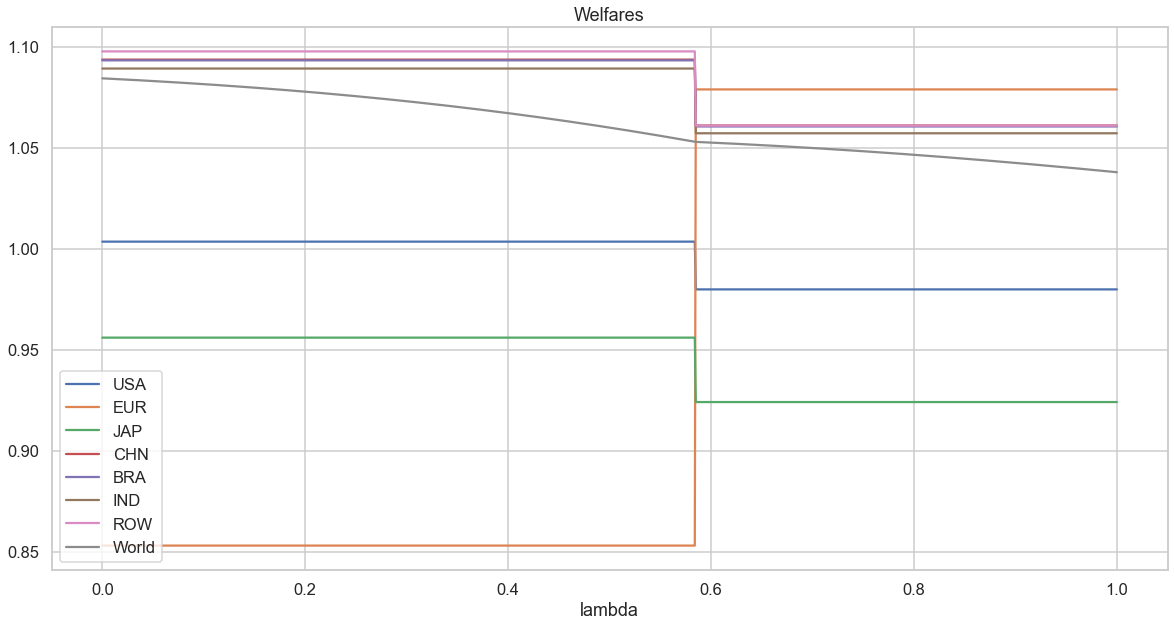

In [243]:
continuous_deltas = pd.read_csv(coop_eq_path+'deltas_from_equal_to_negishi.csv',index_col=0)
continuous_welfares = pd.read_csv(coop_eq_path+'cons_eq_welfares_from_equal_to_negishi.csv')
continuous_deltas.plot(x='lambda',y=p_baseline.countries)
plt.yscale('log')
plt.title('Deltas')
plt.xlabel('lambda')
plt.show()
continuous_welfares.plot(x='aggregation_method',y=p_baseline.countries+['World'])
plt.title('Welfares')
plt.xlabel('lambda')
plt.show()

# Analyzing the complementarity / substitutability between trade and patents

## First we look at the effect of the intensity of trade on patenting

In [244]:
l_sol = []
l_p = []
taus = np.logspace(np.log10(1/2),np.log10(2),111)
for i,tau in enumerate(taus):
    p = p_baseline.copy()
    p.tau = p_baseline.tau*tau
    np.einsum('iis->is',p.tau)[:] = 1
    sol, sol_c = fixed_point_solver(p,x0=p.guess,
                                context = 'counterfactual',
                                cobweb_anim=False,tol =1e-15,
                                accelerate=False,
                                accelerate_when_stable=True,
                                cobweb_qty='profit',
                                plot_convergence=False,
                                plot_cobweb=False,
                                safe_convergence=0.001,
                                disp_summary=False,
                                # apply_bound_psi_star = False,
                                damping = 10,
                                max_count = 1e4,
                                accel_memory = 50, 
                                accel_type1=True, 
                                accel_regularization=1e-10,
                                accel_relaxation=0.5, 
                                accel_safeguard_factor=1, 
                                accel_max_weight_norm=1e6,
                                damping_post_acceleration=5
                                # damping=10
                                  # apply_bound_psi_star=True
                                )
    sol_c.compute_non_solver_quantities(p)
    sol_c.compute_consumption_equivalent_welfare(p,sol_baseline)
    sol_c.compute_world_welfare_changes(p,sol_baseline)
    if sol.status != 'successful':
        print('failed',tau)
        break
    p.guess = sol_c.vector_from_var()
    l_sol.append(sol_c)
    l_p.append(p)

Note : this counterfactual is done on the trade costs of all sectors

As we would expect, the welfares all increase wih a facilitated trade. ROW would be the biggest winner of an easier trade and the biggest loser from a hindered trade

The growth rate is non monotonic but overall decreases with larger trade costs

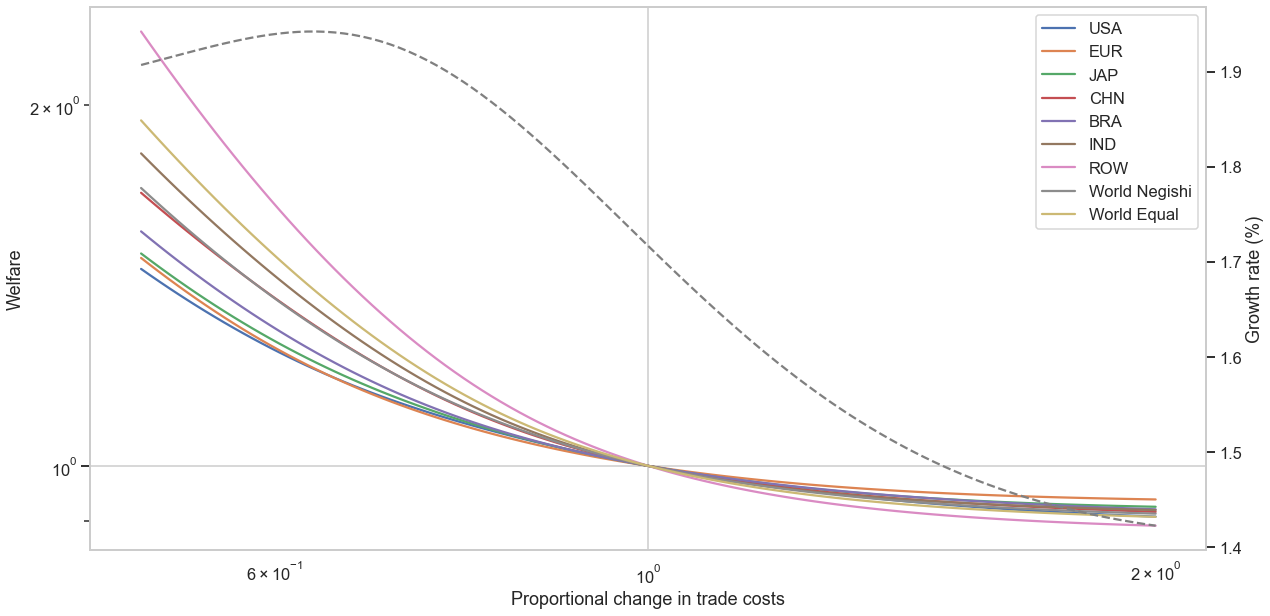

In [171]:
welfares = pd.DataFrame(columns = ['taus']+p_baseline.countries)

welfares['taus'] = taus

display(Markdown(f'Note : this counterfactual is done on the trade costs of all sectors'))
display(Markdown(f'As we would expect, the welfares all increase wih a facilitated trade. ROW would be the biggest winner of an easier trade and the biggest loser from a hindered trade'))
display(Markdown(f'The growth rate is non monotonic but overall decreases with larger trade costs'))


fig, ax = plt.subplots()
ax2 = ax.twinx()
for i,c in enumerate(p_baseline.countries):
    welfares[c] = [sol.cons_eq_welfare[i] for sol in l_sol]
    ax.plot(welfares['taus'],welfares[c],color=sns.color_palette()[i],label=c)

welfares['Negishi'] = [sol.cons_eq_negishi_welfare_change for sol in l_sol]
ax.plot(welfares['taus'],welfares['Negishi'],color=sns.color_palette()[i+1],label='World Negishi')

welfares['Equal'] = [sol.cons_eq_pop_average_welfare_change for sol in l_sol]
ax.plot(welfares['taus'],welfares['Equal'],color=sns.color_palette()[i+2],label='World Equal')
    
ax2.plot(welfares['taus'],np.array([sol.g for sol in l_sol])*100, label = 'Growth rate',color='grey',ls='--')
ax2.set_ylabel('Growth rate (%)')

ax.set_xlabel('Proportional change in trade costs')
ax.set_ylabel('Welfare')
ax.set_yscale('log')
plt.xscale('log')
ax.legend()
# ax2.legend()
ax2.grid(False)
plt.show()

Echo-ing the growth rate change, the change in the total number of patents is non-monotonic, but mostly decreasing with less intense trade.

An interesting result is the change in the share of domestic patenting. The share of patents that are domestic increases with a hindered trade

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


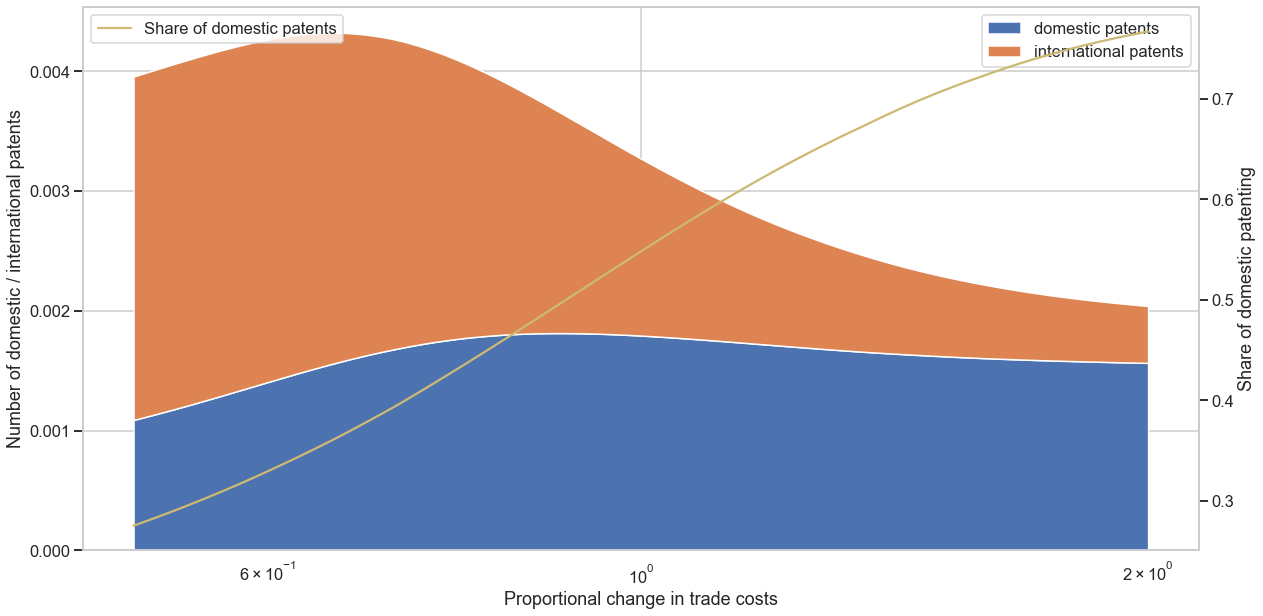

In [245]:
display(Markdown(f'Echo-ing the growth rate change, the change in the total number of patents is non-monotonic, but mostly decreasing with less intense trade.'))
display(Markdown(f'An interesting result is the change in the share of domestic patenting. The share of patents that are domestic increases with a hindered trade'))

patent_number = pd.DataFrame()

patent_number['taus'] = taus
patent_number['domestic patents'] = [np.einsum('ii->',sol.pflow) for sol in l_sol]
patent_number['international patents'] = [np.einsum('ni->',sol.pflow)-np.einsum('ii->',sol.pflow) for sol in l_sol]

fig, ax = plt.subplots()

ax2 = ax.twinx()
ax2.grid(False)

ax.stackplot(patent_number['taus'],patent_number['domestic patents'],patent_number['international patents'],labels = ('domestic patents', 'international patents'))
plt.xscale('log')
ax.set_xlabel('Proportional change in trade costs')
ax.legend()
ax2.plot(patent_number['taus'],patent_number['domestic patents']/(patent_number['domestic patents']+patent_number['international patents']),
         label='Share of domestic patents',color='y')
ax2.legend()
ax2.set_ylabel('Share of domestic patenting')
ax.set_ylabel('Number of domestic / international patents')

# for save_format in ['eps','png','pdf']:
#         plt.savefig('additional_material/'+baseline+'_'+variation+'_additional_material/patent_numbers_function_of_trade_costs.'+save_format,format=save_format)

plt.show()

## We could look more in depth at the effect of changing a specific trade cost. For example, say that we change the trade cost USA-CHN

In [231]:
l_sol = []
l_p = []
taus = np.logspace(np.log10(1/2),np.log10(2),111)
for i,tau in enumerate(taus):
    p = p_baseline.copy()
    p.tau[0,3,:] = p_baseline.tau[0,3,:]*tau
    sol, sol_c = fixed_point_solver(p,x0=p.guess,
                                context = 'counterfactual',
                                cobweb_anim=False,tol =1e-15,
                                accelerate=False,
                                accelerate_when_stable=True,
                                cobweb_qty='profit',
                                plot_convergence=False,
                                plot_cobweb=False,
                                safe_convergence=0.001,
                                disp_summary=False,
                                # apply_bound_psi_star = False,
                                damping = 10,
                                max_count = 1e4,
                                accel_memory = 50, 
                                accel_type1=True, 
                                accel_regularization=1e-10,
                                accel_relaxation=0.5, 
                                accel_safeguard_factor=1, 
                                accel_max_weight_norm=1e6,
                                damping_post_acceleration=5
                                # damping=10
                                  # apply_bound_psi_star=True
                                )
    sol_c.compute_non_solver_quantities(p)
    sol_c.compute_consumption_equivalent_welfare(p,sol_baseline)
    sol_c.compute_world_welfare_changes(p,sol_baseline)
    if sol.status != 'successful':
        print('failed',tau)
        break
    p.guess = sol_c.vector_from_var()
    l_sol.append(sol_c)
    l_p.append(p)

Note : this counterfactual is done on the trade costs of all sectors, and is not symmetric, the trade cost CHN-USA is left the same.

In terms of welfare, China is the most sensitive to this change

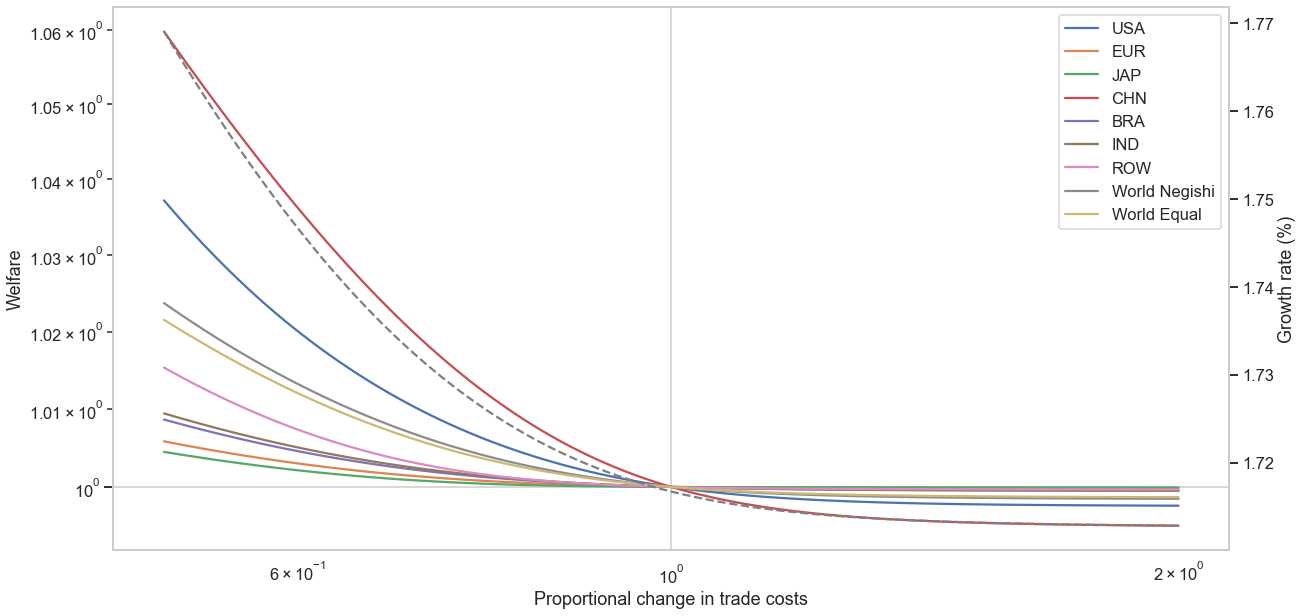

In [181]:
welfares = pd.DataFrame(columns = ['taus']+p_baseline.countries)

welfares['taus'] = taus

display(Markdown(f'Note : this counterfactual is done on the trade costs of all sectors, and is not symmetric, the trade cost CHN-USA is left the same.'))
display(Markdown(f'In terms of welfare, China is the most sensitive to this change'))


fig, ax = plt.subplots()
ax2 = ax.twinx()
for i,c in enumerate(p_baseline.countries):
    welfares[c] = [sol.cons_eq_welfare[i] for sol in l_sol]
    ax.plot(welfares['taus'],welfares[c],color=sns.color_palette()[i],label=c)

welfares['Negishi'] = [sol.cons_eq_negishi_welfare_change for sol in l_sol]
ax.plot(welfares['taus'],welfares['Negishi'],color=sns.color_palette()[i+1],label='World Negishi')

welfares['Equal'] = [sol.cons_eq_pop_average_welfare_change for sol in l_sol]
ax.plot(welfares['taus'],welfares['Equal'],color=sns.color_palette()[i+2],label='World Equal')
    
ax2.plot(welfares['taus'],np.array([sol.g for sol in l_sol])*100, label = 'Growth rate',color='grey',ls='--')
ax2.set_ylabel('Growth rate (%)')

ax.set_xlabel('Proportional change in trade costs')
ax.set_ylabel('Welfare')
ax.set_yscale('log')
plt.xscale('log')
ax.legend()
# ax2.legend()
ax2.grid(False)
plt.show()

With a facilitated trade flow USA-CHN, we would see less patents in the US and more patents in China

With a hindered trade flow USA-CHN, we would see less patents by the US and less patents by China

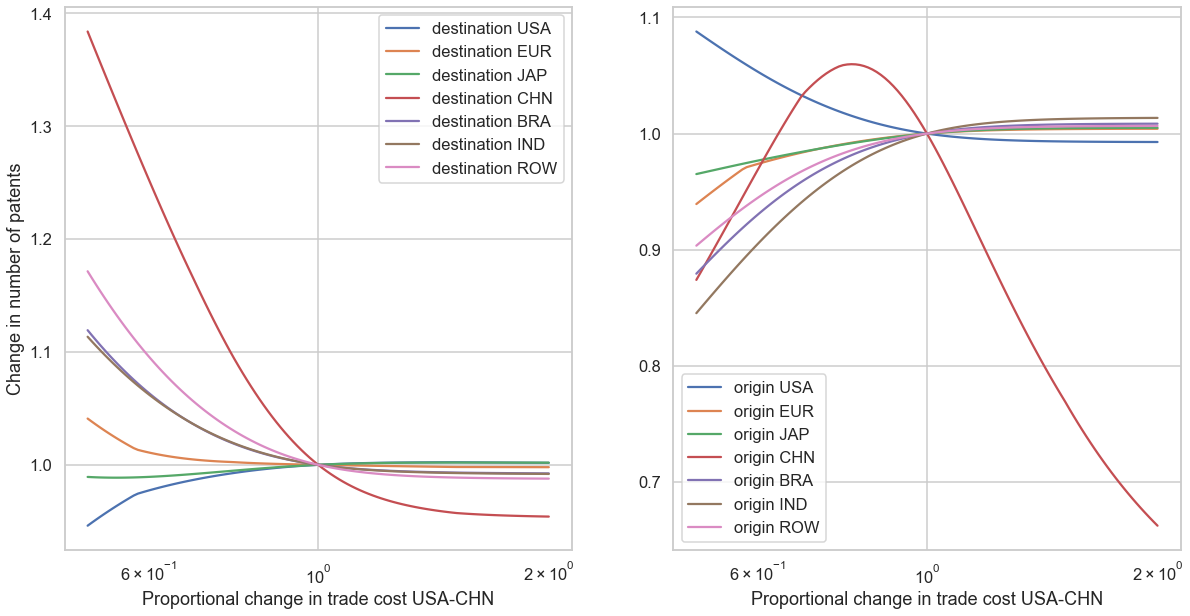

In [182]:
display(Markdown(f'With a facilitated trade flow USA-CHN, we would see less patents in the US and more patents in China'))
display(Markdown(f'With a hindered trade flow USA-CHN, we would see less patents by the US and less patents by China'))

patent_number = pd.DataFrame(columns=['taus']+['destination '+c for c in p.countries]+['origin '+c for c in p.countries])

patent_number['taus'] = taus
for i,country in enumerate(p_baseline.countries):
    patent_number['destination '+country] = [sol.pflow[i,:].sum()/sol_baseline.pflow[i,:].sum() for sol in l_sol]
    patent_number['origin '+country] = [sol.pflow[:,i].sum()/sol_baseline.pflow[:,i].sum() for sol in l_sol]

fig, ax = plt.subplots(1,2)

for i,country in enumerate(p_baseline.countries):
    ax[0].plot(patent_number['taus'],patent_number['destination '+country],label = 'destination '+country)
    ax[1].plot(patent_number['taus'],patent_number['origin '+country],label = 'origin '+country)
    
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel('Proportional change in trade cost USA-CHN')
ax[1].set_xlabel('Proportional change in trade cost USA-CHN')
ax[0].legend()
ax[1].legend()
# ax2.plot(patent_number['taus'],patent_number['domestic patents']/(patent_number['domestic patents']+patent_number['international patents']),
#          label='Share of domestic patents',color='y')
# ax2.legend()
# ax2.set_ylabel('Share of domestic patenting')
ax[0].set_ylabel('Change in number of patents')

plt.show()

## Effect of trade on the unilateral patent protection counterfactuals. 
We want to see how a change in the trade costs will change the derivatives $$\frac{\partial CEW_n}{\partial \delta_n}$$

In [246]:
derivatives = pd.DataFrame(columns = ['taus']+p_baseline.countries)

for i,sol_c in tqdm(enumerate(l_sol)):
    p = l_p[i]
    derivatives.loc[i,'taus'] = taus[i]
    for j,country in enumerate(p_baseline.countries):
        p_cf = p.copy()
        p_cf.delta[j,1] = p_cf.delta[j,1]*1.1
        sol, sol_c = fixed_point_solver(p_cf,x0=p_cf.guess,
                                    context = 'counterfactual',
                                    cobweb_anim=False,tol =1e-15,
                                    accelerate=False,
                                    accelerate_when_stable=True,
                                    cobweb_qty='profit',
                                    plot_convergence=False,
                                    plot_cobweb=False,
                                    safe_convergence=0.001,
                                    disp_summary=False,
                                    # apply_bound_psi_star = False,
                                    damping = 10,
                                    max_count = 1e4,
                                    accel_memory = 50, 
                                    accel_type1=True, 
                                    accel_regularization=1e-10,
                                    accel_relaxation=0.5, 
                                    accel_safeguard_factor=1, 
                                    accel_max_weight_norm=1e6,
                                    damping_post_acceleration=5
                                    # damping=10
                                      # apply_bound_psi_star=True
                                    )
        sol_c.compute_non_solver_quantities(p_cf)
        sol_c.compute_consumption_equivalent_welfare(p_cf,sol_baseline)
        sol_c.compute_world_welfare_changes(p_cf,sol_baseline)
        
        derivatives.loc[i,country] = (sol_c.cons_eq_welfare[j]-l_sol[i].cons_eq_welfare[j])/(0.1*p.delta[j,1])
    
    

111it [03:16,  1.77s/it]


Japan has the largest sensitivity of its welfare to its patent protection policy : d(welfare)/delta, ROW the lowest

All countries would have a more sensitive welfare-to-patent-protection in a world with more trade

The US would see the largest change in this sensivity if trade is facilitated / hindered

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


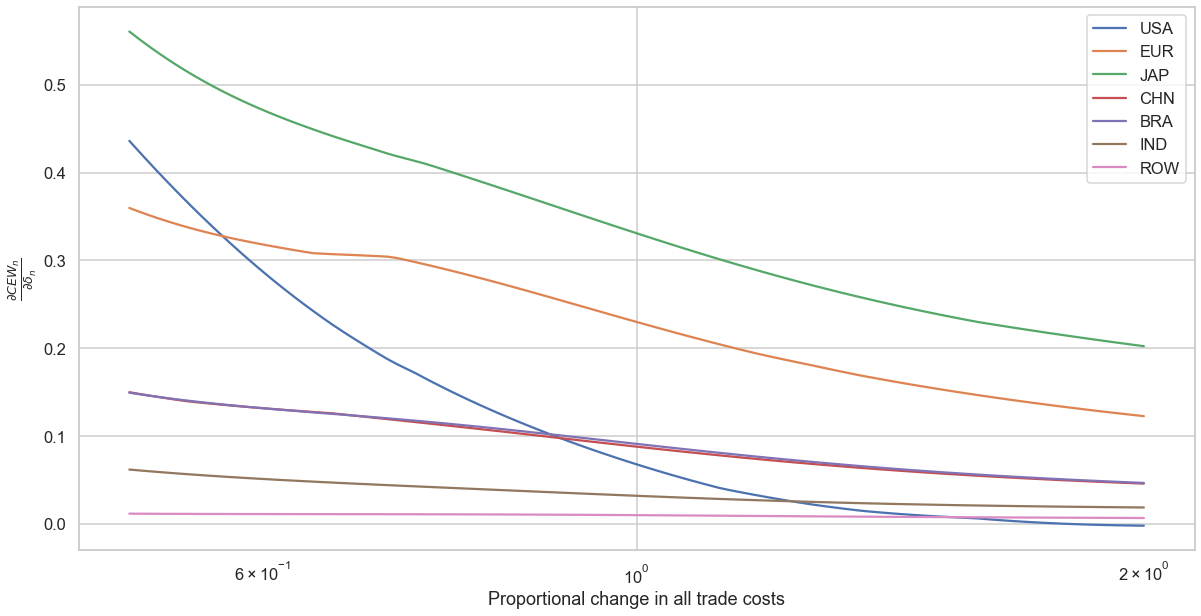

In [247]:
display(Markdown(f'Japan has the largest sensitivity of its welfare to its patent protection policy : d(welfare)/delta, ROW the lowest'))
display(Markdown(f'All countries would have a more sensitive welfare-to-patent-protection in a world with more trade'))
display(Markdown(f'The US would see the largest change in this sensivity if trade is facilitated / hindered'))
derivatives.plot(x='taus',y=p_baseline.countries)
plt.ylabel(r'$\frac{\partial CEW_n}{\partial \delta_n}$')
plt.xlabel('Proportional change in all trade costs')
plt.xscale('log')
# for save_format in ['eps','png','pdf']:
#         plt.savefig('additional_material/'+baseline+'_'+variation+'_additional_material/derivative_welfare_delta_function_of_trade_costs.'+save_format,format=save_format)
plt.show()

## Next we look at the effect of patent protection on trade

In [248]:
l_sol = []
l_p = []
deltas = np.logspace(-1,1,111)
for i,delta in enumerate(deltas):
    p = p_baseline.copy()
    p.delta[:,1] = p_baseline.delta[:,1]*delta
    np.einsum('iis->is',p.tau)[:] = 1
    sol, sol_c = fixed_point_solver(p,x0=p.guess,
                                context = 'counterfactual',
                                cobweb_anim=False,tol =1e-15,
                                accelerate=False,
                                accelerate_when_stable=True,
                                cobweb_qty='profit',
                                plot_convergence=False,
                                plot_cobweb=False,
                                safe_convergence=0.001,
                                disp_summary=False,
                                # apply_bound_psi_star = False,
                                damping = 10,
                                max_count = 1e4,
                                accel_memory = 50, 
                                accel_type1=True, 
                                accel_regularization=1e-10,
                                accel_relaxation=0.5, 
                                accel_safeguard_factor=1, 
                                accel_max_weight_norm=1e6,
                                damping_post_acceleration=5
                                # damping=10
                                  # apply_bound_psi_star=True
                                )
    sol_c.compute_non_solver_quantities(p)
    sol_c.compute_consumption_equivalent_welfare(p,sol_baseline)
    sol_c.compute_world_welfare_changes(p,sol_baseline)
    if sol.status != 'successful':
        print('failed',delta)
        break
    p.guess = sol_c.vector_from_var()
    l_sol.append(sol_c)
    l_p.append(p)

The share of goods traded increases with stronger patent protection

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


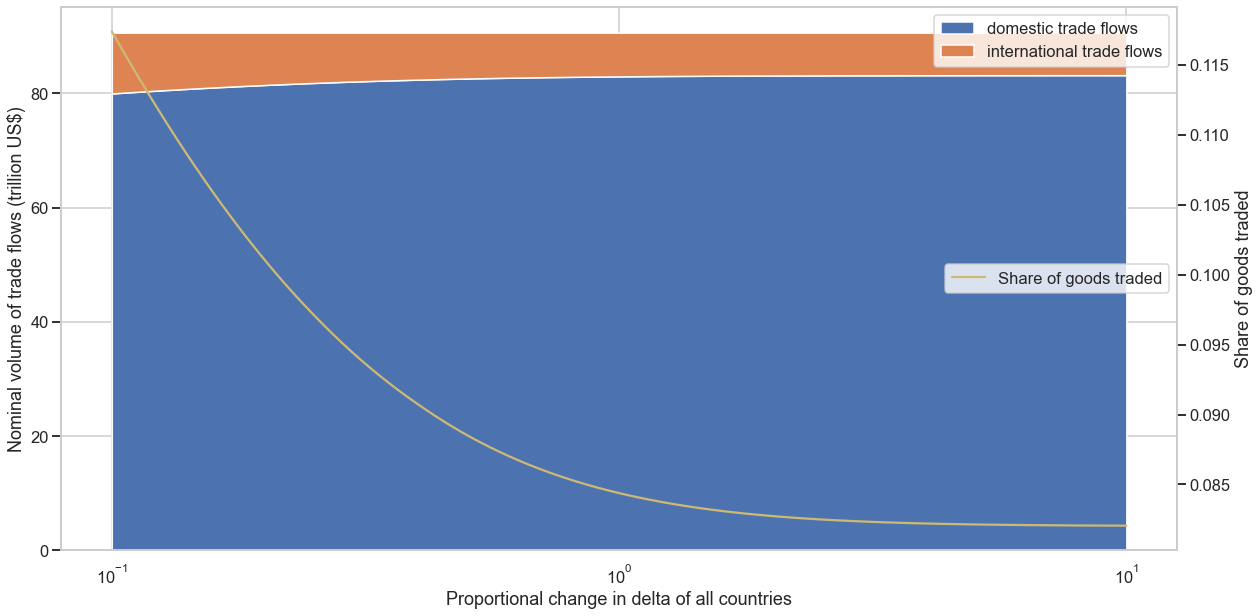

In [249]:
display(Markdown(f'The share of goods traded increases with stronger patent protection'))
display(Markdown(f''))

trade_flows = pd.DataFrame()

trade_flows['delta'] = deltas
trade_flows['domestic trade flows'] = [np.einsum('iis->',sol.X) for sol in l_sol]
trade_flows['international trade flows'] = [np.einsum('nis->',sol.X)-np.einsum('iis->',sol.X) for sol in l_sol]

fig, ax = plt.subplots()

ax2 = ax.twinx()
ax2.grid(False)

ax.stackplot(trade_flows['delta'],trade_flows['domestic trade flows'],trade_flows['international trade flows'],
             labels = ('domestic trade flows', 'international trade flows'))
plt.xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Proportional change in delta of all countries')
ax.legend()
ax2.plot(trade_flows['delta'],trade_flows['international trade flows']/(trade_flows['domestic trade flows']+trade_flows['international trade flows']),
         label='Share of goods traded',color='y')
ax2.legend(loc='center right')
ax2.set_ylabel('Share of goods traded')
ax.set_ylabel('Nominal volume of trade flows (trillion US$)')

# for save_format in ['eps','png','pdf']:
#         plt.savefig('additional_material/'+baseline+'_'+variation+'_additional_material/trade_flows_function_of_global_patent_protection.'+save_format,format=save_format)

plt.show()

# The role of diffusion

In [ ]:
l_sol = []
l_p = []
nus = np.logspace(-1,1,111)
for i,nu in enumerate(nus):
    p = p_baseline.copy()
    p.nu[1] = p_baseline.nu[1]*nu
    sol, sol_c = fixed_point_solver(p,x0=p.guess,
                                context = 'counterfactual',
                                cobweb_anim=False,tol =1e-15,
                                accelerate=False,
                                accelerate_when_stable=True,
                                cobweb_qty='profit',
                                plot_convergence=False,
                                plot_cobweb=False,
                                safe_convergence=0.001,
                                disp_summary=False,
                                # apply_bound_psi_star = False,
                                damping = 10,
                                max_count = 1e4,
                                accel_memory = 50, 
                                accel_type1=True, 
                                accel_regularization=1e-10,
                                accel_relaxation=0.5, 
                                accel_safeguard_factor=1, 
                                accel_max_weight_norm=1e6,
                                damping_post_acceleration=5
                                # damping=10
                                  # apply_bound_psi_star=True
                                )
    sol_c.compute_non_solver_quantities(p)
    sol_c.compute_consumption_equivalent_welfare(p,sol_baseline)
    sol_c.compute_world_welfare_changes(p,sol_baseline)
    if sol.status != 'successful':
        print('failed',nu)
        break
    p.guess = sol_c.vector_from_var()
    l_sol.append(sol_c)
    l_p.append(p)

The effects on welfare and the growth rate are interesting. Opposite to the rest of the countries, the US would benefit from slower diffusion.

For large increases, every country would see a much faster diffusion speed as negative.

For the World as an aggregate, there is an optimal diffusion speed, at nu_optimal = 1.585*nu_calibrated according to Negishi aggregate (with a world welfare gain of 1.08%)

For the World as an aggregate, there is an optimal diffusion speed, at nu_optimal = 1.954*nu_calibrated according to Equal aggregate (with a world welfare gain of 2.51%)

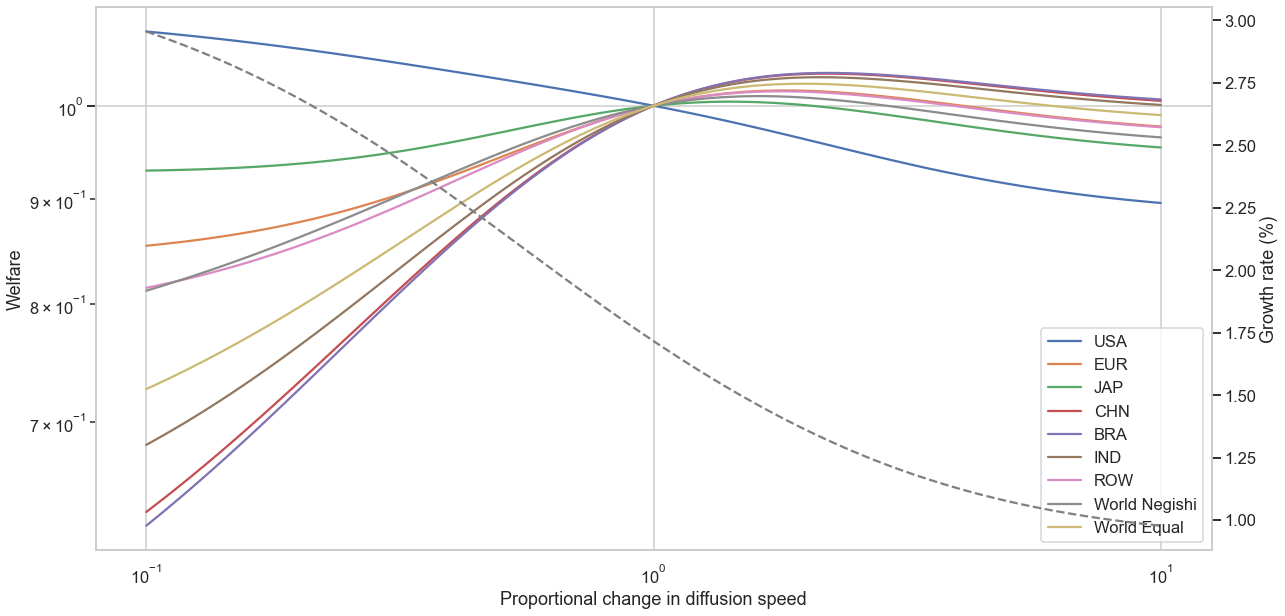

In [197]:
welfares = pd.DataFrame(columns = ['nu']+p_baseline.countries)

welfares['nu'] = nus

display(Markdown(f'The effects on welfare and the growth rate are interesting. Opposite to the rest of the countries, the US would benefit from slower diffusion.'))
display(Markdown(f'For large increases, every country would see a much faster diffusion speed as negative.'))
display(Markdown(f'For the World as an aggregate, there is an optimal diffusion speed, at nu_optimal = 1.585*nu_calibrated according to Negishi aggregate (with a world welfare gain of 1.08%)'))
display(Markdown(f'For the World as an aggregate, there is an optimal diffusion speed, at nu_optimal = 1.954*nu_calibrated according to Equal aggregate (with a world welfare gain of 2.51%)'))

fig, ax = plt.subplots()
ax2 = ax.twinx()
for i,c in enumerate(p_baseline.countries):
    welfares[c] = [sol.cons_eq_welfare[i] for sol in l_sol]
    ax.plot(welfares['nu'],welfares[c],color=sns.color_palette()[i],label=c)

welfares['Negishi'] = [sol.cons_eq_negishi_welfare_change for sol in l_sol]
ax.plot(welfares['nu'],welfares['Negishi'],color=sns.color_palette()[i+1],label='World Negishi')

welfares['Equal'] = [sol.cons_eq_pop_average_welfare_change for sol in l_sol]
ax.plot(welfares['nu'],welfares['Equal'],color=sns.color_palette()[i+2],label='World Equal')
    
ax2.plot(welfares['nu'],np.array([sol.g for sol in l_sol])*100, label = 'Growth rate',color='grey',ls='--')
ax2.set_ylabel('Growth rate (%)')

ax.set_xlabel('Proportional change in diffusion speed')
ax.set_ylabel('Welfare')
ax.set_yscale('log')
plt.xscale('log')
ax.legend()
# ax2.legend()
ax2.grid(False)
plt.show()

Not surprisingly, the number of total patents increases with the diffusion speed.

It reaches a plateau when certain thresholds of "all innovations are patented" are reached. The main break in slope corresponds to all US inventions are patented in the US

It is interesting that the number of domestic actually decreases at some point, as the number of international patents keep growing.

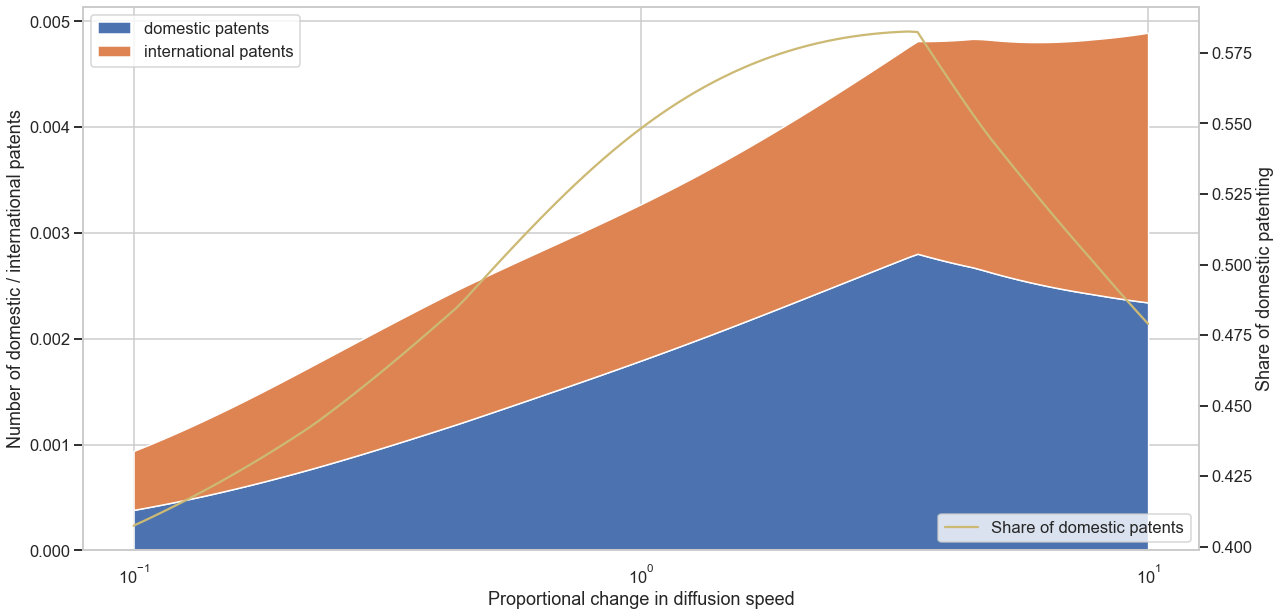

In [220]:
display(Markdown(f'Not surprisingly, the number of total patents increases with the diffusion speed.'))
display(Markdown(f'It reaches a plateau when certain thresholds of "all innovations are patented" are reached. The main break in slope corresponds to all US inventions are patented in the US'))
display(Markdown(f'It is interesting that the number of domestic actually decreases at some point, as the number of international patents keep growing.'))


patent_number = pd.DataFrame()

patent_number['nus'] = nus
patent_number['total patents'] = [sol.pflow.sum() for sol in l_sol]
patent_number['domestic patents'] = [np.einsum('ii->',sol.pflow) for sol in l_sol]
patent_number['international patents'] = [np.einsum('ni->',sol.pflow)-np.einsum('ii->',sol.pflow) for sol in l_sol]
patent_number['average share of innovations patented'] = [np.diagonal(sol.share_innov_patented).mean() for sol in l_sol]

fig, ax = plt.subplots()

ax2 = ax.twinx()
ax2.grid(False)

ax.stackplot(patent_number['nus'],patent_number['domestic patents'],patent_number['international patents'],labels = ('domestic patents', 'international patents'))
plt.xscale('log')
ax.set_xlabel('Proportional change in diffusion speed')
ax.legend(loc='upper left')
ax2.plot(patent_number['nus'],patent_number['domestic patents']/(patent_number['domestic patents']+patent_number['international patents']),
         label='Share of domestic patents',color='y')
ax2.legend(loc='lower right')
ax2.set_ylabel('Share of domestic patenting')
ax.set_ylabel('Number of domestic / international patents')

plt.show()